In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import anndata as ad
import pandas as pd
import scanpy as sc
from core.normalize import *
from plotmodules.norm_plots import *
from core.test_model import test_abundance
from plotnine import ggplot, geom_point, aes, facet_wrap, geom_line, geom_hline, geom_text, geom_vline, xlab, ylab, xlim, ggtitle, geom_boxplot, labs

ROSMAP_PATH = 'ROSMAP_clinical.csv'
CT_COUNTS_META_PATH = 'ct_counts_public_meta.h5ad'

ROSMAP_data = pd.read_csv(ROSMAP_PATH)
ct_counts_metadata = ad.read_h5ad(CT_COUNTS_META_PATH)


In [2]:
# Remove outliers

from core.outliers import *

calculate_ct_per_median(ct_counts_metadata, 'Exc RELN CHD7', column_name='RELN_metric')
thresh = np.percentile(ct_counts_metadata.obs['RELN_metric'], 97)
ct_counts_metadata = remove_outliers(ct_counts_metadata, 'RELN_metric', thresh)

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/outliers.py:38: RuntimeWarning: invalid value encountered in scalar divide
/home/jacob/Documents/BEP/bsc-thesis-scripts/core/outliers.py:38: RuntimeWarning: divide by zero encountered in scalar divide


In [3]:
normalize_tmm(ct_counts_metadata, layer_name='norm')
test_abundance(ct_counts_metadata, norm_layer='norm')
abundant_cells = ct_counts_metadata.var.index[ct_counts_metadata.var['significant'] == True].to_list()
ct_counts_metadata.var.sort_values('corr_pvalue')

/home/jacob/Documents/BEP/bsc-thesis-scripts/core/normalize.py:71: ImplicitModificationWarning: Setting element `.layers['norm']` of view, initializing view as actual.


,significant,corr_pvalue
Inh L3-5 SST MAFB,True,0.003075
Inh CUX2 MSR1,True,0.004225
Inh LAMP5 RELN,True,0.010948
Inh VIP TSHZ2,True,0.011438
OPCs,True,0.011829
Inh ENOX2 SPHKAP,True,0.023933
Inh PTPRK FAM19A1,True,0.039495
Inh L1 PAX6 CA4,True,0.048821
Inh SORCS1 TTN,False,0.053564
Inh GPC5 RIT2,False,0.053564


In [4]:
# Process data into the regression df
data = pd.DataFrame(ct_counts_metadata.X, columns=ct_counts_metadata.var.index, index=ct_counts_metadata.obs.index)
data['cogdx'] = ct_counts_metadata.obs['cogdx']
data['pmi'] = ct_counts_metadata.obs['pmi']
data = data[(data.cogdx == 5) | (data.cogdx == 4) | (data.cogdx == 1)]
data['cogdx_cat'] = data['cogdx'].map({4: 'AD', 5: 'AD', 1: 'H'}).astype('category')
data['cogdx_catcodes'] = data['cogdx_cat'].cat.codes
data = data.dropna(axis=0, how='any')
data

,Ast CHI3L1,Ast DPP10,Ast GRM3,CAMs,End,Exc L3-4 RORB CUX2,Exc L3-5 RORB PLCH1,Exc L4-5 RORB GABRG1,Exc L4-5 RORB IL1RAPL2,Exc L5 ET,...,Mic TPT1,OPCs,Oligodendrocytes,Per,SMC,T cells,cogdx,pmi,cogdx_cat,cogdx_catcodes
projid,,,,,,,,,,,,,,,,,,,,,
1211411,160.0,65.0,119.0,0.0,2.0,548.0,121.0,261.0,350.0,2.0,...,2.0,171.0,939.0,7.0,1.0,0.0,4.0,6.500000,AD,0
3713990,14.0,58.0,492.0,2.0,11.0,406.0,64.0,118.0,315.0,8.0,...,6.0,262.0,1315.0,9.0,0.0,0.0,1.0,4.333333,H,1
6107196,0.0,8.0,35.0,1.0,3.0,52.0,8.0,56.0,54.0,0.0,...,1.0,79.0,1036.0,5.0,0.0,1.0,4.0,4.166667,AD,0
7253015,2.0,20.0,225.0,9.0,11.0,445.0,92.0,190.0,268.0,10.0,...,8.0,146.0,821.0,12.0,3.0,6.0,4.0,4.166667,AD,0
7265221,534.0,211.0,102.0,6.0,32.0,682.0,130.0,266.0,425.0,12.0,...,32.0,292.0,1113.0,21.0,5.0,6.0,4.0,5.750000,AD,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92629514,29.0,37.0,249.0,1.0,17.0,291.0,51.0,65.0,187.0,14.0,...,16.0,167.0,520.0,12.0,2.0,1.0,4.0,5.350000,AD,0
94092977,5.0,82.0,138.0,3.0,11.0,674.0,146.0,271.0,439.0,6.0,...,15.0,234.0,1645.0,8.0,5.0,6.0,4.0,5.716667,AD,0
95491648,97.0,45.0,6.0,1.0,19.0,169.0,46.0,92.0,182.0,3.0,...,1.0,112.0,3338.0,12.0,1.0,3.0,1.0,5.583333,H,1


In [5]:
melted_data = data[abundant_cells + ['cogdx', 'pmi', 'cogdx_cat', 'cogdx_catcodes']].melt(['cogdx', 'pmi', 'cogdx_cat', 'cogdx_catcodes'])
melted_data

,cogdx,pmi,cogdx_cat,cogdx_catcodes,variable,value
0,4.0,6.500000,AD,0,Inh CUX2 MSR1,39.0
1,1.0,4.333333,H,1,Inh CUX2 MSR1,60.0
2,4.0,4.166667,AD,0,Inh CUX2 MSR1,17.0
3,4.0,4.166667,AD,0,Inh CUX2 MSR1,63.0
4,4.0,5.750000,AD,0,Inh CUX2 MSR1,23.0
...,...,...,...,...,...,...
2355,4.0,5.350000,AD,0,OPCs,167.0
2356,4.0,5.716667,AD,0,OPCs,234.0
2357,1.0,5.583333,H,1,OPCs,112.0
2358,1.0,5.933333,H,1,OPCs,260.0


In [6]:
# Train logistic models
regression_fits = pd.DataFrame(columns=abundant_cells)
for ct in abundant_cells:
    m = smf.glm(f'cogdx_catcodes ~ Q("{ct}")*pmi -1', data=data, family=sm.families.Binomial()).fit()
    regression_fits[ct] = m.fittedvalues
    print(m.summary())

melted_data['fittedvalues'] = regression_fits.melt()['value']

                 Generalized Linear Model Regression Results                  
Dep. Variable:         cogdx_catcodes   No. Observations:                  295
Model:                            GLM   Df Residuals:                      292
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -198.23
Date:                Tue, 14 May 2024   Deviance:                       396.47
Time:                        16:15:10   Pearson chi2:                     295.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04057
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Q("Inh CUX2 MSR1")        -0

/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.


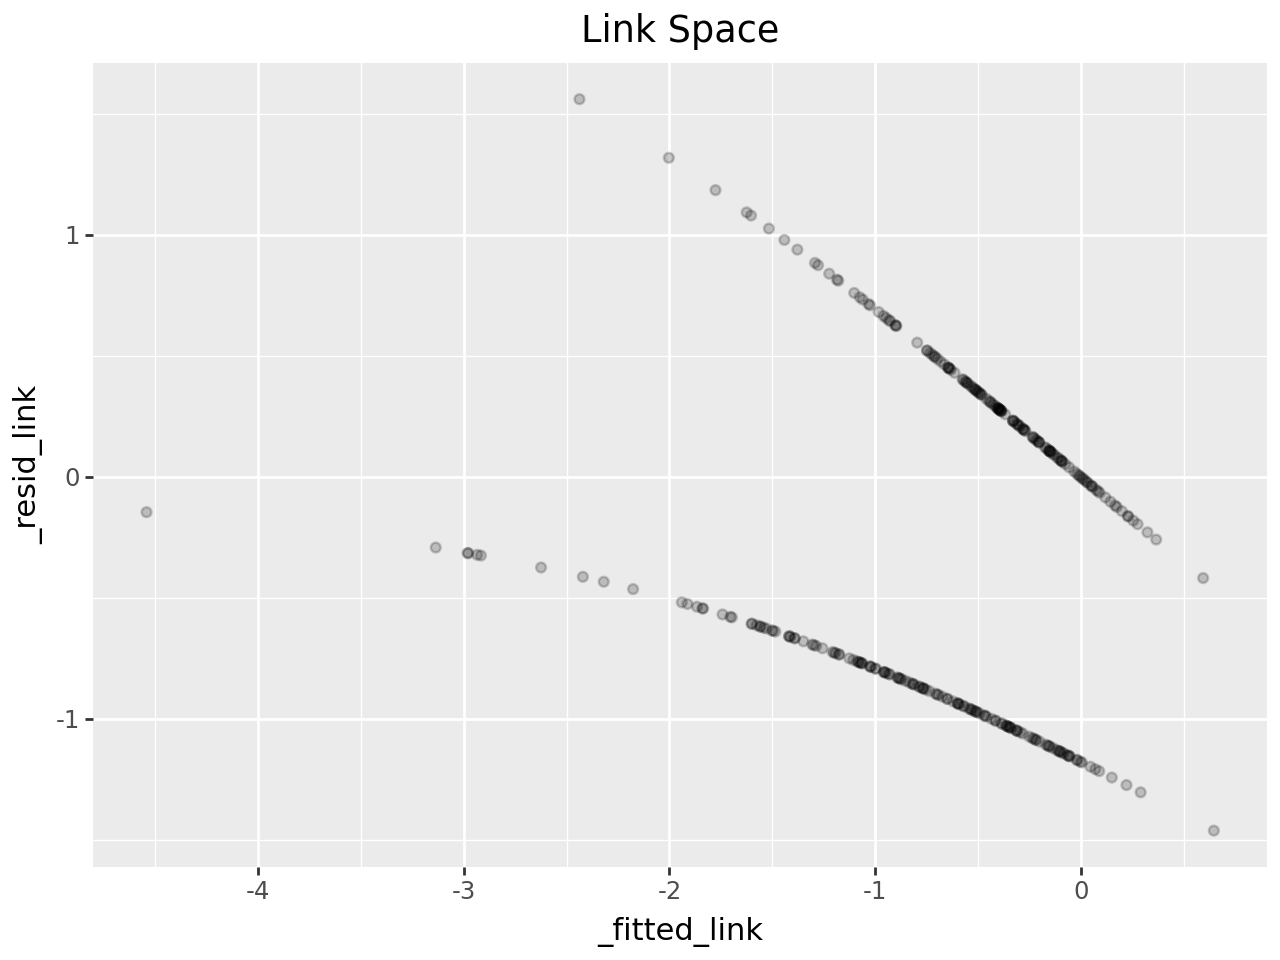

In [7]:
# Test across all 
formula = 'cogdx_catcodes ~ ' + ' + '.join(f'Q("{ct}")' for ct in ct_counts_metadata.var.index.tolist()) + ' - 1'
m = smf.glm(formula, data=data, family=sm.families.NegativeBinomial()).fit()
summary_tables = m.summary().tables
#display(summary_tables[1])

# Plot link space
link_df = pd.DataFrame({'_resid_link': m.resid_deviance, '_fitted_link': m.family.link(m.fittedvalues)})
link = ggplot(link_df, aes('_fitted_link', '_resid_link')) +\
    geom_point(alpha=0.2) +\
    ggtitle('Link Space')
link

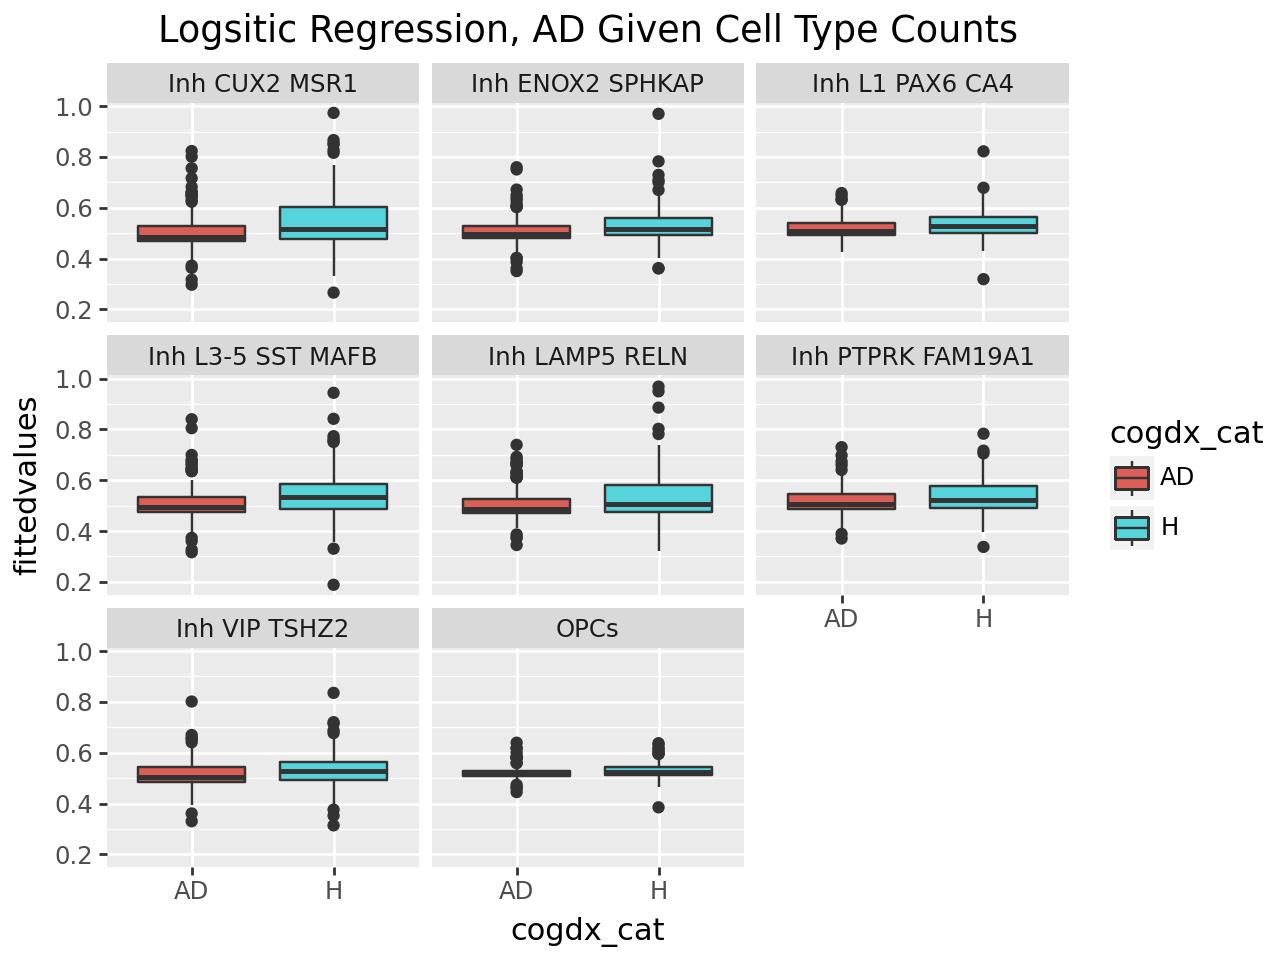

In [8]:
#display(melted_data)

plot = ggplot(melted_data, aes(y='fittedvalues', x='cogdx_cat', fill='cogdx_cat')) +\
    geom_boxplot() +\
    facet_wrap('variable') +\
    ggtitle('Logsitic Regression, AD Given Cell Type Counts')

plot

In [9]:
# Fold change

fold_changes = np.zeros(len(ct_counts_metadata.X.T))
normalize_l1(ct_counts_metadata, 'norm_l1_notrans', None)
for i, ct in enumerate(ct_counts_metadata.var.index):
    AD = ct_counts_metadata.layers['norm_l1_notrans'][(ct_counts_metadata.obs.cogdx == 4) | (ct_counts_metadata.obs.cogdx == 5), i]
    H = ct_counts_metadata.layers['norm_l1_notrans'][ct_counts_metadata.obs.cogdx == 1, i]
    fold_changes[i] = np.log2(np.mean(AD)/np.mean(H))

ct_counts_metadata.var = ct_counts_metadata.var.assign(log2fc=fold_changes, log10p=np.log10(ct_counts_metadata.var['corr_pvalue'])*-1)
ct_counts_metadata.var.sort_values('corr_pvalue')

,significant,corr_pvalue,log2fc,log10p
Inh L3-5 SST MAFB,True,0.003075,-0.297636,2.512225
Inh CUX2 MSR1,True,0.004225,-0.370136,2.374183
Inh LAMP5 RELN,True,0.010948,-0.369481,1.960653
Inh VIP TSHZ2,True,0.011438,-0.166178,1.941633
OPCs,True,0.011829,-0.047118,1.927061
Inh ENOX2 SPHKAP,True,0.023933,-0.191873,1.620997
Inh PTPRK FAM19A1,True,0.039495,-0.275218,1.403462
Inh L1 PAX6 CA4,True,0.048821,-0.189847,1.311395
Inh SORCS1 TTN,False,0.053564,-0.204627,1.271127
Inh GPC5 RIT2,False,0.053564,-0.125034,1.271127


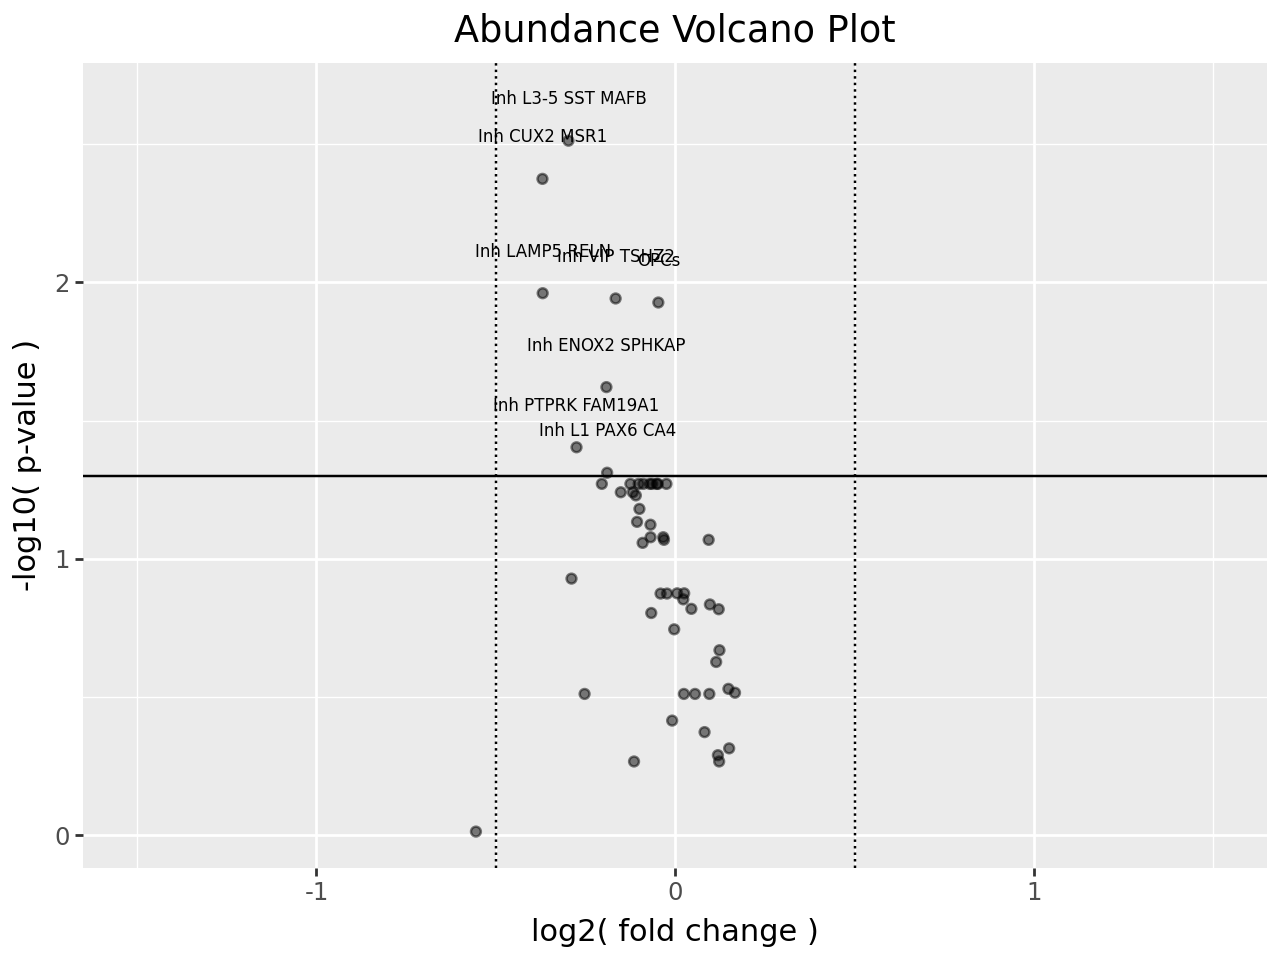

In [10]:
alpha=0.05
ct_counts_metadata.var = ct_counts_metadata.var.reset_index()
volcano_plot = ggplot(ct_counts_metadata.var, aes('log2fc', 'log10p')) +\
    geom_point(alpha=0.5) +\
    geom_hline(yintercept=np.log10(alpha)*-1, color='black') +\
    geom_text(aes(label='index'), data=ct_counts_metadata.var[ct_counts_metadata.var['significant'] == True], color='black', nudge_y=0.15, size=6) +\
    geom_vline(xintercept=(0.5, -0.5), color='black', linetype='dotted') +\
    xlab('log2( fold change )') + ylab('-log10( p-value )') +\
    xlim(-1.5, 1.5) +\
    ggtitle('Abundance Volcano Plot')

volcano_plot